In [474]:
import osmnx as ox
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPoint, LineString, MultiLineString
from tqdm import tqdm
import shapely
from shapely import geometry, ops
from shapely.ops import linemerge
import momepy

import matplotlib.pyplot as plt
import math

# import neatnet
# from my_tools import *
# import shutup
# shutup.please()
# from multiprocessing import Pool

In [475]:
def get_slope(line):
    l = len(line.xy[0])-1
    x1, y1, x2, y2 = line.xy[0][0], line.xy[1][0], line.xy[0][l], line.xy[1][l]
    if x2 == x1: # straight vertical line
        return np.inf
    return (y2 - y1) / (x2 - x1)

    
def delta_angle(line1, line2): # angle between two lines
    slope1 = get_slope(line1)
    slope2 = get_slope(line2)

    if slope1 == np.inf and slope2 == np.inf:
        return 0
    
    elif slope1 == np.inf:
        return 90-math.degrees(abs(math.atan(slope2)))

    elif slope2 == np.inf:
        return 90-math.degrees(abs(math.atan(slope1)))
    
    elif slope1 * slope2 == -1:
        return 90

    else:
        angle_radians = math.atan(abs((slope2 - slope1) / (1 + slope1 * slope2)))
        angle_degrees = math.degrees(angle_radians)

        return angle_degrees


def new_angles(G):
    nodes = G.nodes(data=True)
    for edges in list(G.edges()):
        u, v = edges
        a =  nodes[u]['geometry']
        b =  nodes[v]['geometry']
        touch_point = a.intersection(b)
        
        if type(touch_point)!=Point:
            angle=delta_angle(a,b)
        else: 
            thresh_cut = 5
            touch_point_b=touch_point.buffer(thresh_cut*2)
            cut_a = a.difference(a.difference(touch_point_b)) 
            cut_b = b.difference(b.difference(touch_point_b))
            cut_b = check_string(cut_b,touch_point)
            cut_a = check_string(cut_a,touch_point)
            angle = delta_angle(cut_a, cut_b)
        
        G[u][v]['new_angle'] = angle

    return G

def check_string(l,p):
    if type(l) == MultiLineString:
        for i in l.geoms:
            if i.touches(p):
                return i
    else: 
        return l


def merged_G_angle(G,tresh,attr):
    H = G.copy() 

    # find components that have a similar angle and merge them
    filtered_H = H.copy()
    edges_to_remove = [(u, v) for u, v, a in H.edges(data=True) if (a[attr] > tresh) or (a[attr] > (180 - tresh))]
    filtered_H.remove_edges_from(edges_to_remove)

    # Find connected components (groups of nodes to merge)
    components = [H.subgraph(c).copy() for c in nx.connected_components(filtered_H)]
    lengths = nx.get_node_attributes(G, "mm_len")
    geometries = nx.get_node_attributes(G, "geometry")
    
    mapping = {}
    length_map = {}
    geom_map = {}
    
    for comp in components:
        nodes = list(comp.nodes())
        
        # Merge by mean node coordinate
        mean_node = tuple(np.mean(np.array(nodes), axis=0))
        mapping.update({n: mean_node for n in nodes})
        
        # Sum up lengths
        length_map[mean_node] = np.sum([lengths.get(n, 0) for n in nodes])
        
        # Merge geometries (LineStrings → MultiLineString → merged line)
        lines = [geometries[n] for n in nodes if n in geometries]
        if lines:
            merged_geom = linemerge(MultiLineString(lines))
            geom_map[mean_node] = merged_geom
    
    # Relabel (merge) nodes in the original graph
    merged_H = nx.relabel_nodes(H, mapping)
    
    # Assign merged attributes
    nx.set_node_attributes(merged_H, length_map, "mm_len")
    nx.set_node_attributes(merged_H, geom_map, "geometry")
    
    return merged_H, mapping, length_map, geom_map

In [476]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  # "drive" for drivable streets

# Consolidate intersections within 5 meters
# G = ox.project_graph(G)  
# G_consolidated = ox.consolidate_intersections(G, tolerance=3, rebuild_graph=True, dead_ends=True)
# edges = ox.graph_to_gdfs(G_consolidated,nodes=False)

edges = ox.graph_to_gdfs(G,nodes=False)
edges.crs = "epsg:4326"
edges = edges.to_crs(3857)

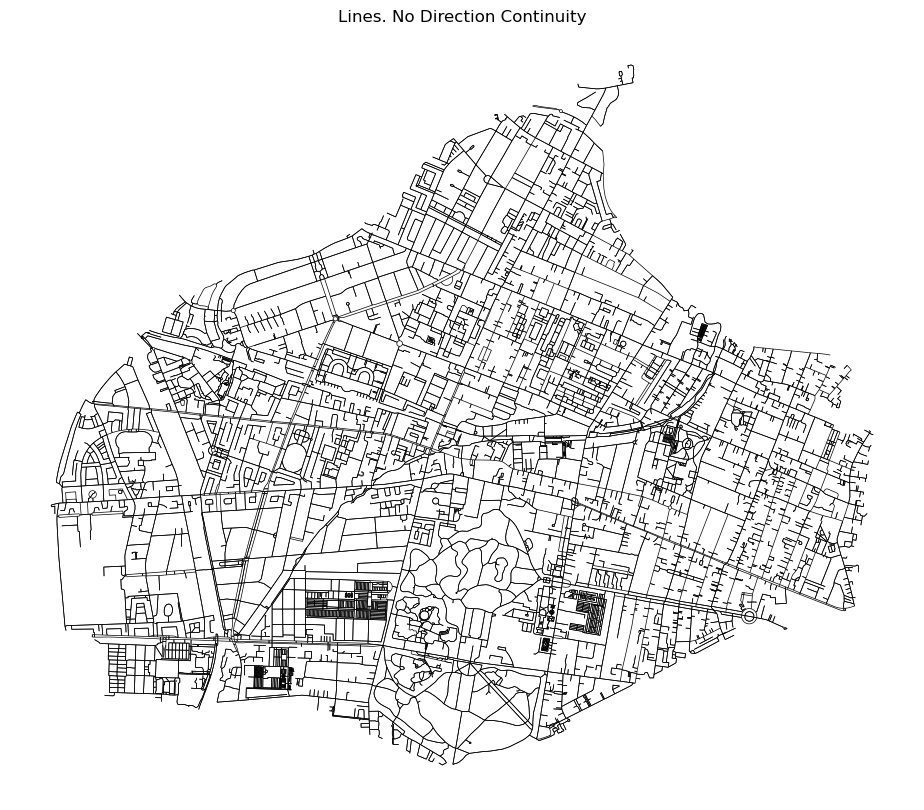

In [477]:
fig, ax = plt.subplots(figsize=(15,10))
edges.plot(ax=ax,color='k',linewidth=0.5)
plt.axis('off')
plt.title('Lines. No Direction Continuity')
plt.show()

In [478]:
G_dual = momepy.gdf_to_nx(edges , approach='dual', multigraph=False, angles=True)
G_dual = new_angles(G_dual)

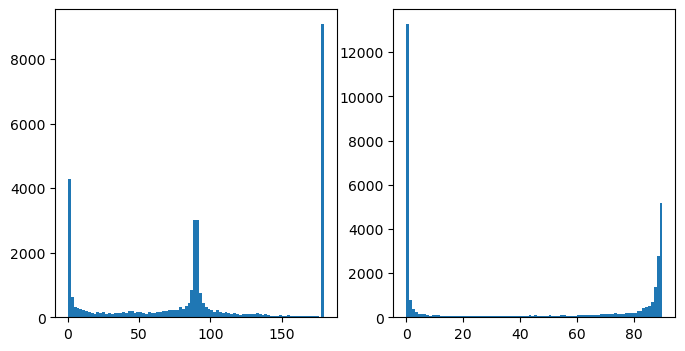

In [487]:
A=nx.get_edge_attributes(G_dual,'angle').values()

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axs[0].hist(nx.get_edge_attributes(G_dual,'angle').values(),bins=90)
axs[1].hist(nx.get_edge_attributes(G_dual,'new_angle').values(),bins=90)

plt.show()

In [488]:
H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=20,attr='new_angle')
df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
gdf_merged['degree']=np.array([d for n, d in H.degree()])

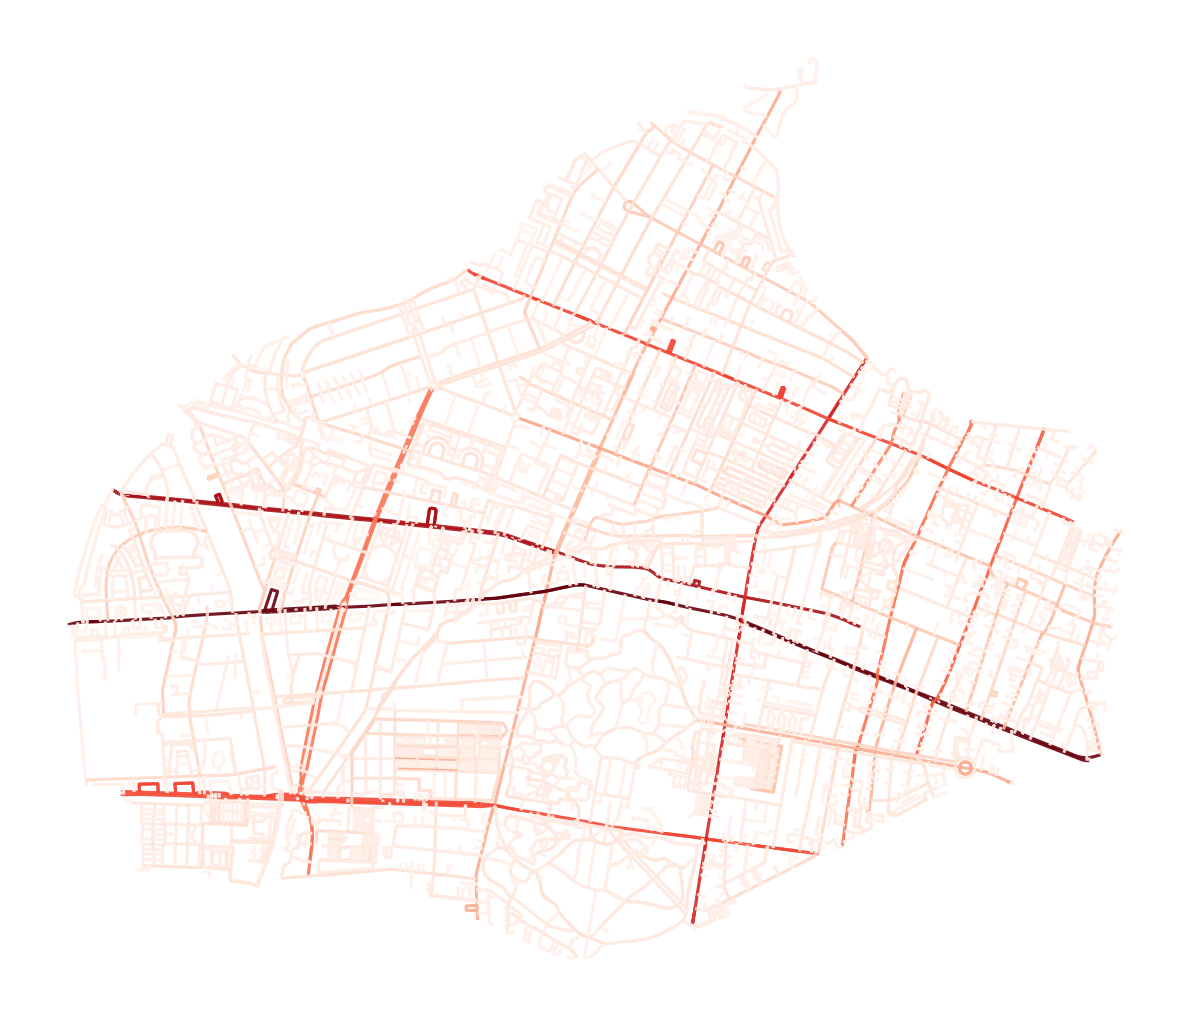

In [490]:
fig, ax = plt.subplots(figsize=(10,10),dpi=150)
gdf_merged.plot(ax=ax,cmap='Reds',alpha=0.9,column='degree')
plt.axis('off')
plt.show()

In [491]:
df_dual_wc = pd.DataFrame(H.degree,columns=['node_id','degree'])

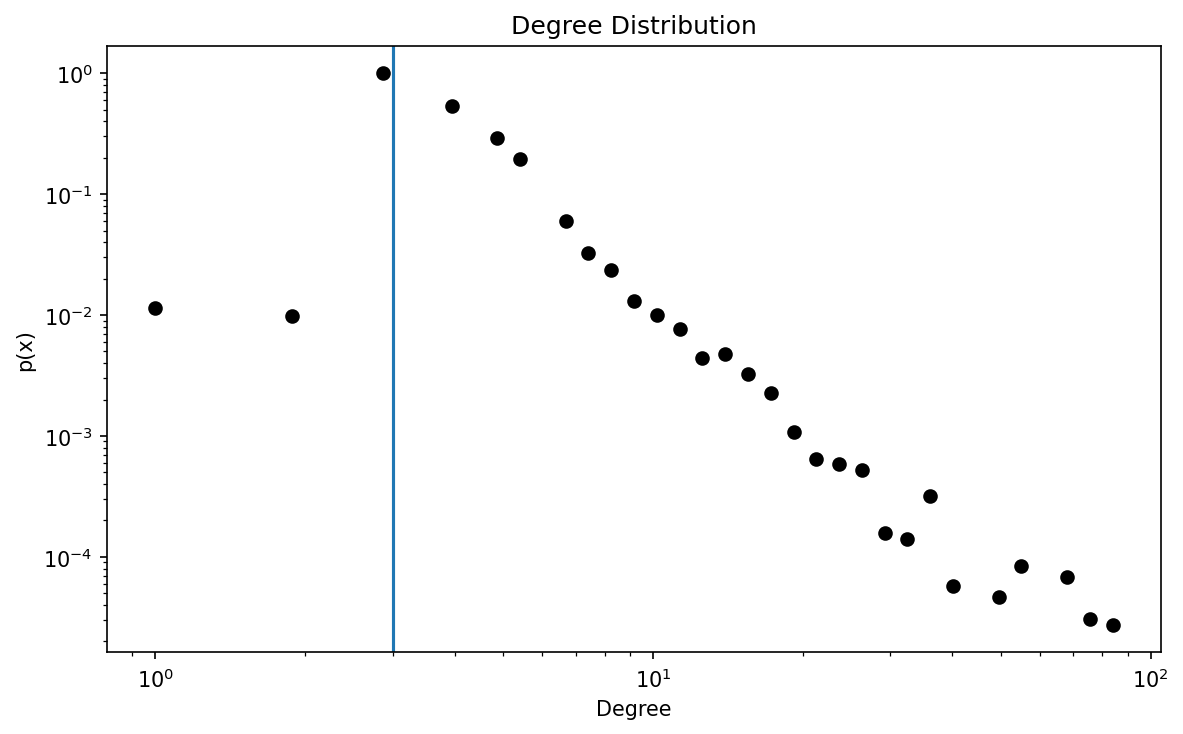

In [ ]:
real_degree_sequence = np.array([d for n, d in H.degree()])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),dpi=150)

# Histogram data
y, x = np.histogram(real_degree_sequence, bins=np.logspace(0, np.log10(real_degree_sequence.max()), len(np.unique(real_degree_sequence))), density=True)
x = x[:-1]
x_nn = x[y != 0][:-1]
y_nn = y[y != 0][:-1]

ax.scatter(x_nn, y_nn, alpha=1, zorder=2, color='k', label='Street Network')
ax.axvline(3)

# Log-log scaling and labels
ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')

plt.title("Degree Distribution")
plt.tight_layout()
plt.show()


# CleanChains

continuity = momepy.COINS(streets)

In [31]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  # "drive" for drivable streets

shape_df = ox.graph_to_gdfs(G,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)
shape_df = shape_df.explode(index_parts=False)
shape_df = gpd.GeoSeries(shape_df.union_all().intersection(shape_df.union_all()), crs=shape_df.crs).explode()
shape_df = gpd.GeoDataFrame(geometry=shape_df)

In [32]:
continuity = momepy.COINS(shape_df,angle_threshold=30,flow_mode=True)

In [74]:
strokes=continuity.stroke_gdf()
# H = momepy.gdf_to_nx(strokes,approach='dual', multigraph=True,angles=False)
strokes['multi'] = strokes['geometry'].apply(lambda x: type(x) == MultiLineString)

# assume gdf is your GeoDataFrame
# def to_linestring(geom):
#     if geom.geom_type == "MultiLineString":
#         return linemerge(geom)
#     return geom

# strokes["geometry"] = strokes.geometry.apply(to_linestring)
strokes = strokes.explode(ignore_index=True)

strokes["geometry"] = strokes.geometry.apply(
    lambda g: linemerge(g) if g.geom_type == "MultiLineString" else g
)

# explode again in case linemerge still returns MultiLineString
strokes = strokes.explode(ignore_index=True)

In [ ]:
dual = momepy.gdf_to_nx(strokes, approach='dual', multigraph=False, angles=True)
H, mapping, length_map, geom_map = merged_G_angle(dual,tresh=30,attr='angle')
df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
gdf_merged['degree']=np.array([d for n, d in H.degree()])
gdf_merged.plot(column='degree',cmap='viridis',linewidth=2)

,,n_segments,multi,geometry,degree,mm_len
1.393745e+06,7.494235e+06,93,False,"LINESTRING (1393408.119 7492614.871, 1393406.3...",0,3333.683630
1.395746e+06,7.494637e+06,63,False,"MULTILINESTRING ((1397766.043 7495269.551, 139...",4,14732.687282
1.393136e+06,7.495158e+06,150,False,"LINESTRING (1396014.075 7494603.53, 1395965.67...",1,5996.914285
1.396028e+06,7.494597e+06,18,False,"LINESTRING (1396012.728 7494598.495, 1396013.1...",4,93.926467
1.393716e+06,7.495634e+06,23,False,"LINESTRING (1394065.816 7495393.391, 1394054.5...",1,984.795028
...,...,...,...,...,...,...
1.393093e+06,7.496216e+06,1,False,"LINESTRING (1393098.717 7496213.625, 1393086.6...",0,13.155230
1.395137e+06,7.494586e+06,2,False,"LINESTRING (1395083.499 7494595.632, 1395165.8...",0,108.360968
1.394749e+06,7.494723e+06,5,False,"LINESTRING (1394759.715 7494755.592, 1394748.9...",0,75.801673
1.393471e+06,7.495859e+06,1,False,"LINESTRING (1393473.686 7495868.077, 1393467.7...",0,18.848353


<Axes: >

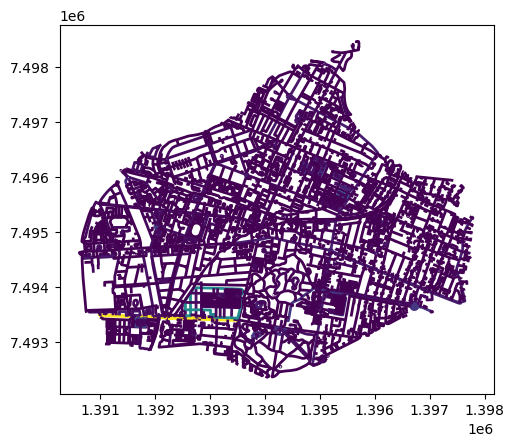

In [ ]:
gdf_merged.plot(column='degree',cmap='viridis',linewidth=2)

In [85]:
shape_df = ox.graph_to_gdfs(G,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)
print(len(shape_df))
shape_df = shape_df.explode(index_parts=False)
print(len(shape_df))
shape_df = gpd.GeoSeries(shape_df.union_all().intersection(shape_df.union_all()), crs=shape_df.crs).explode()
print(len(shape_df))
shape_df = gpd.GeoDataFrame(geometry=shape_df)
# print(len(shape_df))

18920
18920
20038


In [221]:
def combine(elements):
    result_list = []
    for item in elements:
        if isinstance(item, int):
            result_list.append(item)
        elif isinstance(item, list):
            result_list.extend(item)
    return result_list


def clean_chains(G_primal):
    while True:
        nodes_to_remove = []
        
        for node in G_primal.nodes():
            neighbors = list(G_primal.neighbors(node))
            degree = G_primal.degree(node)
            if len(neighbors) == 2 and degree == 2:

                osmIDS = combine([i[2]['osmid'] for i in list(G_primal.edges(node, data=True))])
                lines = [i[2]['geometry'] for i in list(G_primal.edges(node, data=True))]

                multi_line = ops.linemerge(geometry.MultiLineString(lines))

                G_primal.add_edge(neighbors[1], neighbors[0], 
                                id=osmIDS,
                                geometry=multi_line,
                                new_edge=True)

                nodes_to_remove.append(node)
        if not nodes_to_remove: # if empty
            break
        G_primal.remove_nodes_from(nodes_to_remove)

    return G_primal

In [90]:
G = momepy.gdf_to_nx(shape_df, approach="primal")
G = clean_chains(G)
points, lines = momepy.nx_to_gdf(G); del points

<Axes: >

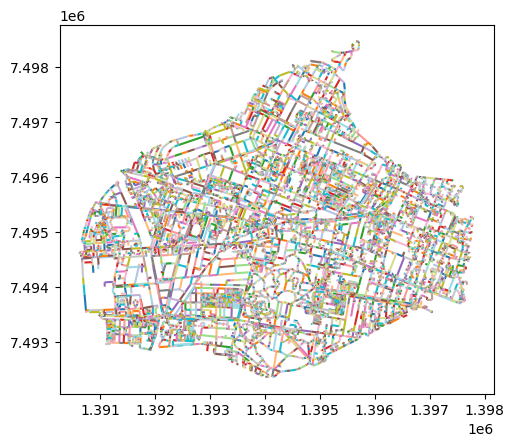

In [81]:
shape_df.sample(frac=1).plot(cmap='tab20')

In [105]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  

In [102]:
shape_df = ox.graph_to_gdfs(G,nodes=False)

In [224]:
from pyrosm import OSM, get_data

# fp = get_data('isle_of_man')
# osm = OSM(fp)

# shape_df = osm.get_network(nodes=False)
# # shape_df.crs = "epsg:4326"
# # shape_df = shape_df.to_crs(3857)
# # shape_df = shape_df.explode(index_parts=False)
# # shape_df = gpd.GeoSeries(shape_df.unary_union.intersection(shape_df.unary_union), crs=shape_df.crs).explode()
# # shape_df = gpd.GeoDataFrame(geometry=shape_df)
# # G = momepy.gdf_to_nx(shape_df, approach="primal"); del shape_df
# # G = clean_chains(G)

# # Explode while keeping original IDs
# shape_df = shape_df.reset_index().explode('geometry')
# shape_df = shape_df.rename(columns={'id': 'orig_id'})

# # Union + intersection, then reattach ids using sjoin
# u = shape_df.union_all()
# i = u.intersection(u)
# out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
# out = out.sjoin(shape_df[['orig_id', 'geometry']], how="left", predicate="intersects")

# out

In [ ]:
def combine(elements):
    result_list = []
    for item in elements:
        if isinstance(item, int):
            result_list.append(item)
        elif isinstance(item, list):
            result_list.extend(item)
    return result_list


def clean_chains(G_primal):
    while True:
        nodes_to_remove = []
        
        for node in G_primal.nodes():
            neighbors = list(G_primal.neighbors(node))
            degree = G_primal.degree(node)
            if len(neighbors) == 2 and degree == 2:

                osmIDS = combine([i[2]['id'] for i in list(G_primal.edges(node, data=True))])
                lines = [i[2]['geometry'] for i in list(G_primal.edges(node, data=True))]

                multi_line = ops.linemerge(geometry.MultiLineString(lines))

                G_primal.add_edge(neighbors[1], neighbors[0], 
                                id=osmIDS,
                                geometry=multi_line,
                                new_edge=True)

                nodes_to_remove.append(node)
                
        if not nodes_to_remove: # if empty
            break
        G_primal.remove_nodes_from(nodes_to_remove)

    return G_primal


In [ ]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  

start = np.random.choice(list(G.nodes))
nodes_within_N = nx.single_source_shortest_path_length(G, start, cutoff=10)
subG = G.subgraph(nodes_within_N.keys()).copy()

shape_df = ox.graph_to_gdfs(subG,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)
edges = ox.graph_to_gdfs(G,nodes=False)

<Axes: >

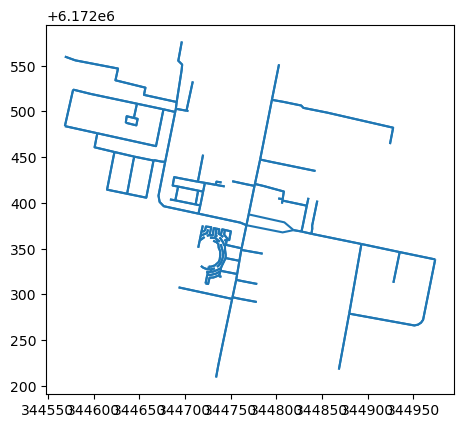

In [ ]:
edges.plot()

In [ ]:
shape_df = ox.graph_to_gdfs(subG,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)


shape_df = shape_df.reset_index().explode('geometry')
shape_df = shape_df.rename(columns={'osmid': 'id'})
u = shape_df.union_all()
i = u.intersection(u)
out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
out = out.sjoin(shape_df[['id', 'geometry']], how="left", predicate="intersects")
G_primal = momepy.gdf_to_nx(out, approach="primal")
G_primal = clean_chains(G_primal)

# _, lines = momepy.nx_to_gdf(G_primal)
# lines.plot(cmap='tab20')
# out.sample(frac=1).plot(cmap='tab20')

# out.sample(frac=1).plot(cmap='tab20')

In [457]:
out

,geometry,index_right,id
0,"LINESTRING (1395415.91 7494552.672, 1395417.71...",1,361179041
0,"LINESTRING (1395415.91 7494552.672, 1395417.71...",0,37395
0,"LINESTRING (1395415.91 7494552.672, 1395417.71...",15,37395
0,"LINESTRING (1395415.91 7494552.672, 1395417.71...",16,37395
0,"LINESTRING (1395415.91 7494552.672, 1395417.71...",20,37395
...,...,...,...
25,"LINESTRING (1395261.366 7494625.306, 1395225.7...",4,1067404923
25,"LINESTRING (1395261.366 7494625.306, 1395225.7...",6,1067404923
25,"LINESTRING (1395261.366 7494625.306, 1395225.7...",8,1430323578
25,"LINESTRING (1395261.366 7494625.306, 1395225.7...",24,1067404923


In [458]:
# for n in G_primal.nodes:
#     t = list(G_primal.edges(n, data=True))

# t

25
26


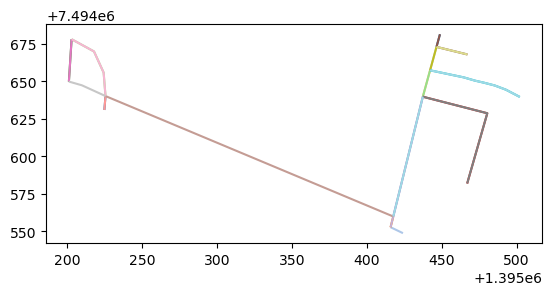

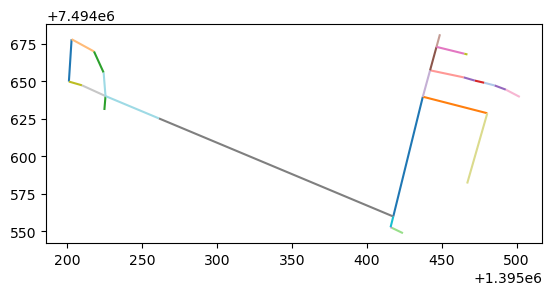

In [408]:
shape_df = ox.graph_to_gdfs(subG,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)

print(len(shape_df))
shape_df.sample(frac=1).plot(cmap='tab20')
shape_df = shape_df.reset_index().explode('geometry')

exploded_lines = gpd.GeoSeries(shape_df.union_all().intersection(shape_df.union_all()), crs=shape_df.crs).explode()
exploded_df = gpd.GeoDataFrame(geometry=exploded_lines)
exploded_df.sample(frac=1).plot(cmap='tab20')
print(len(exploded_df))

In [433]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  

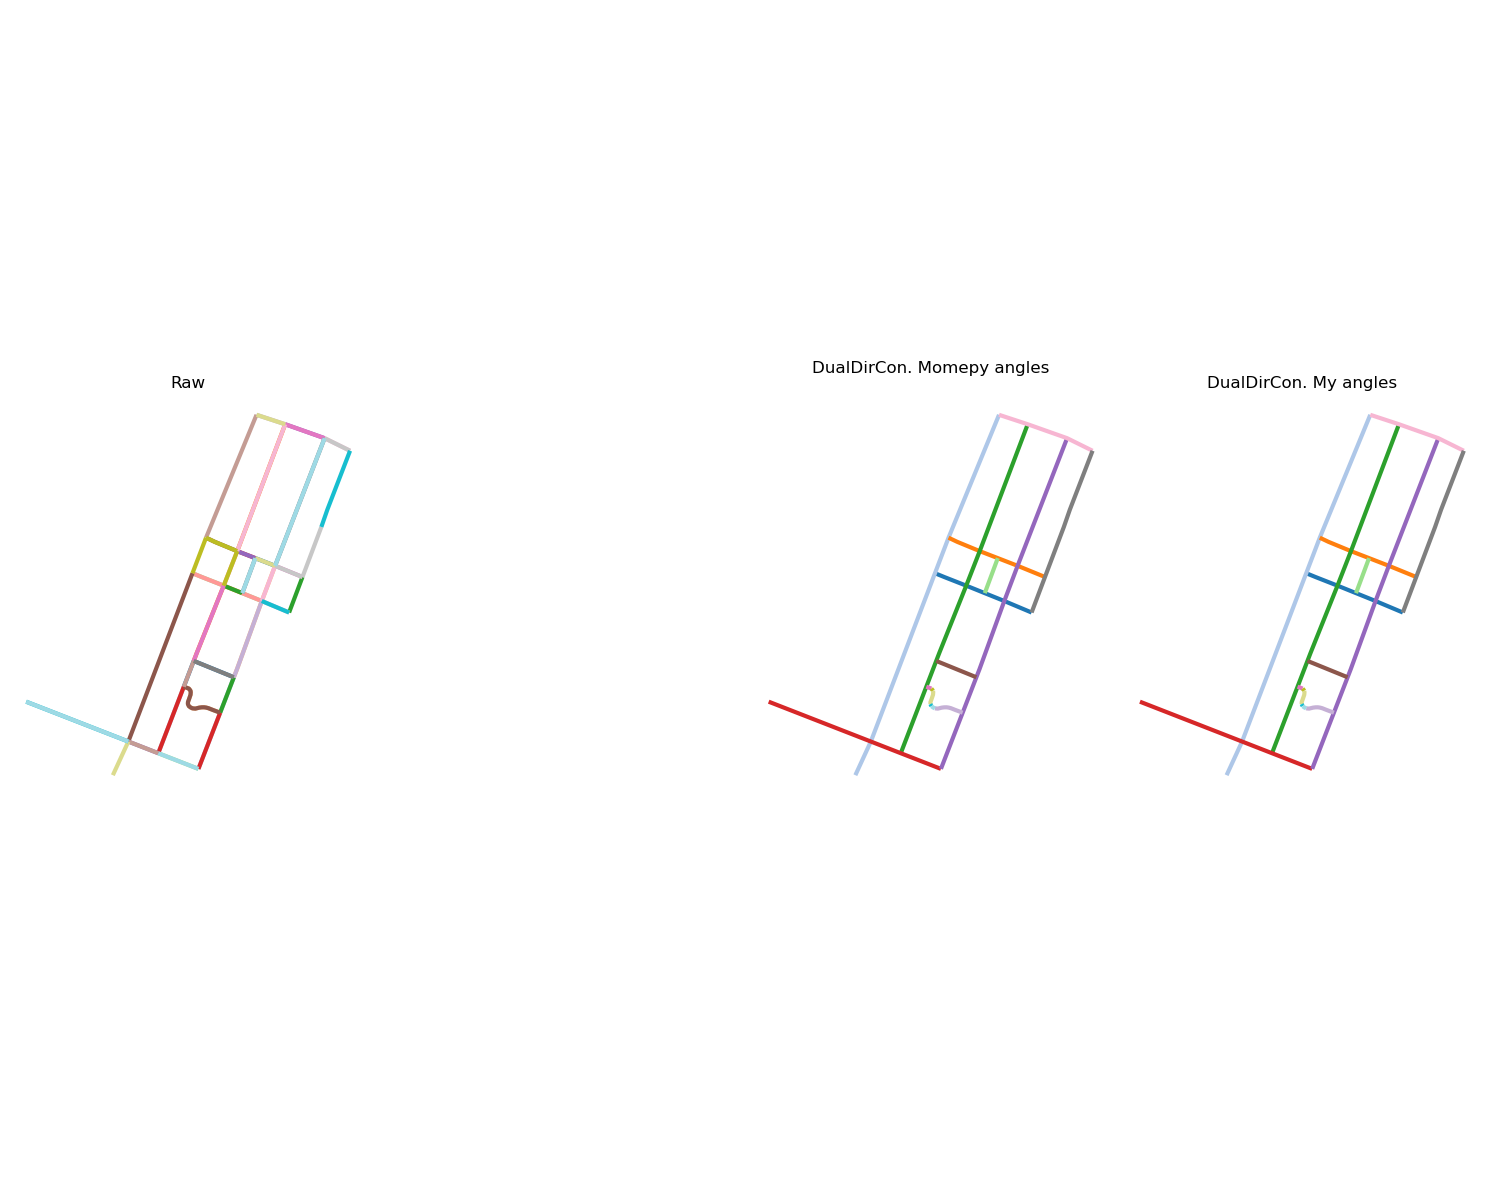

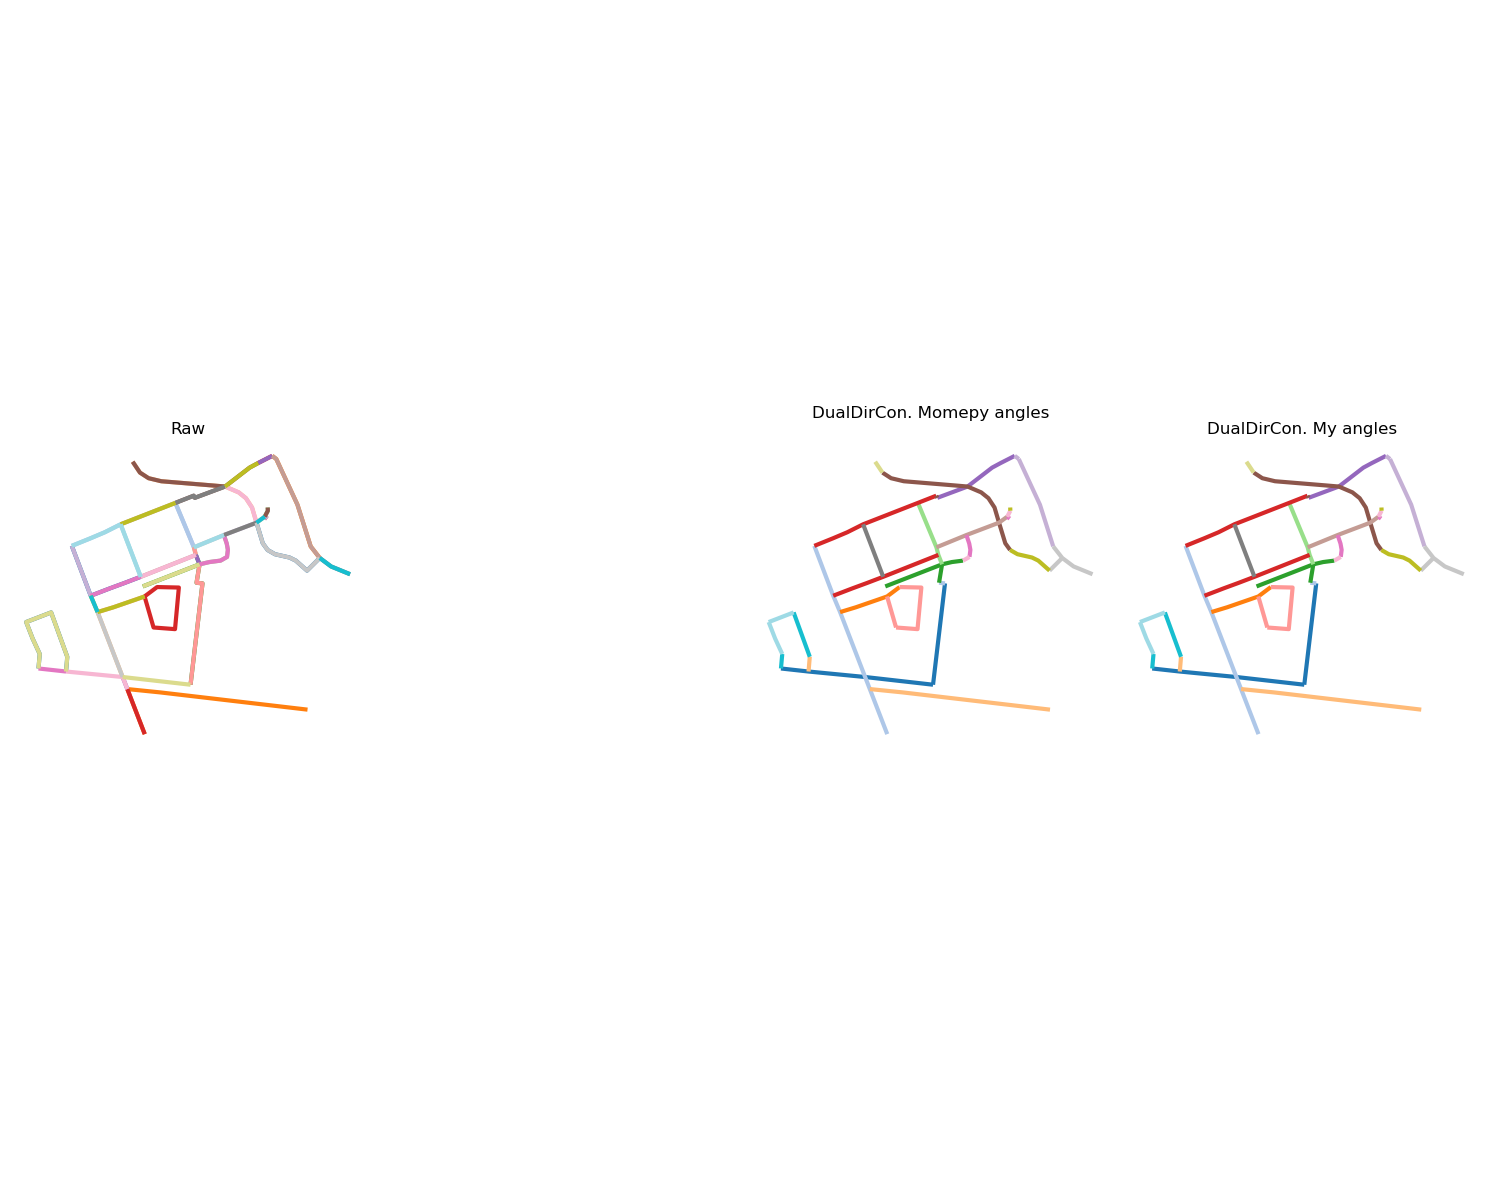

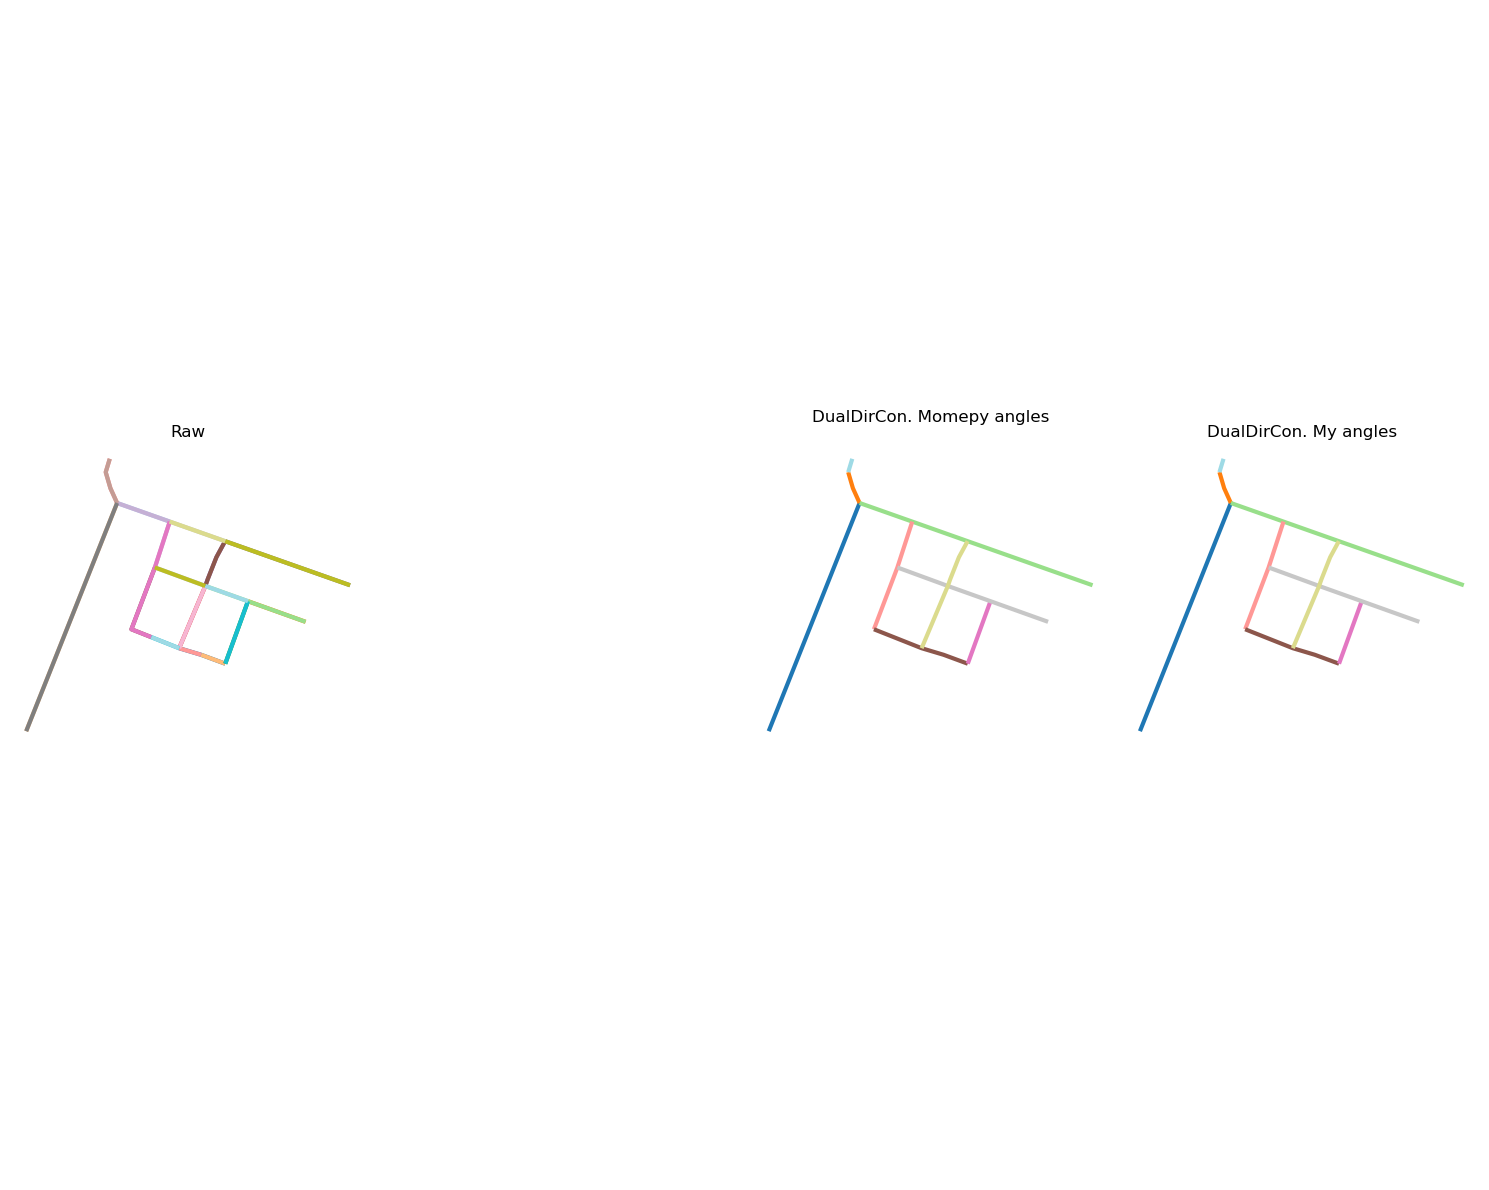

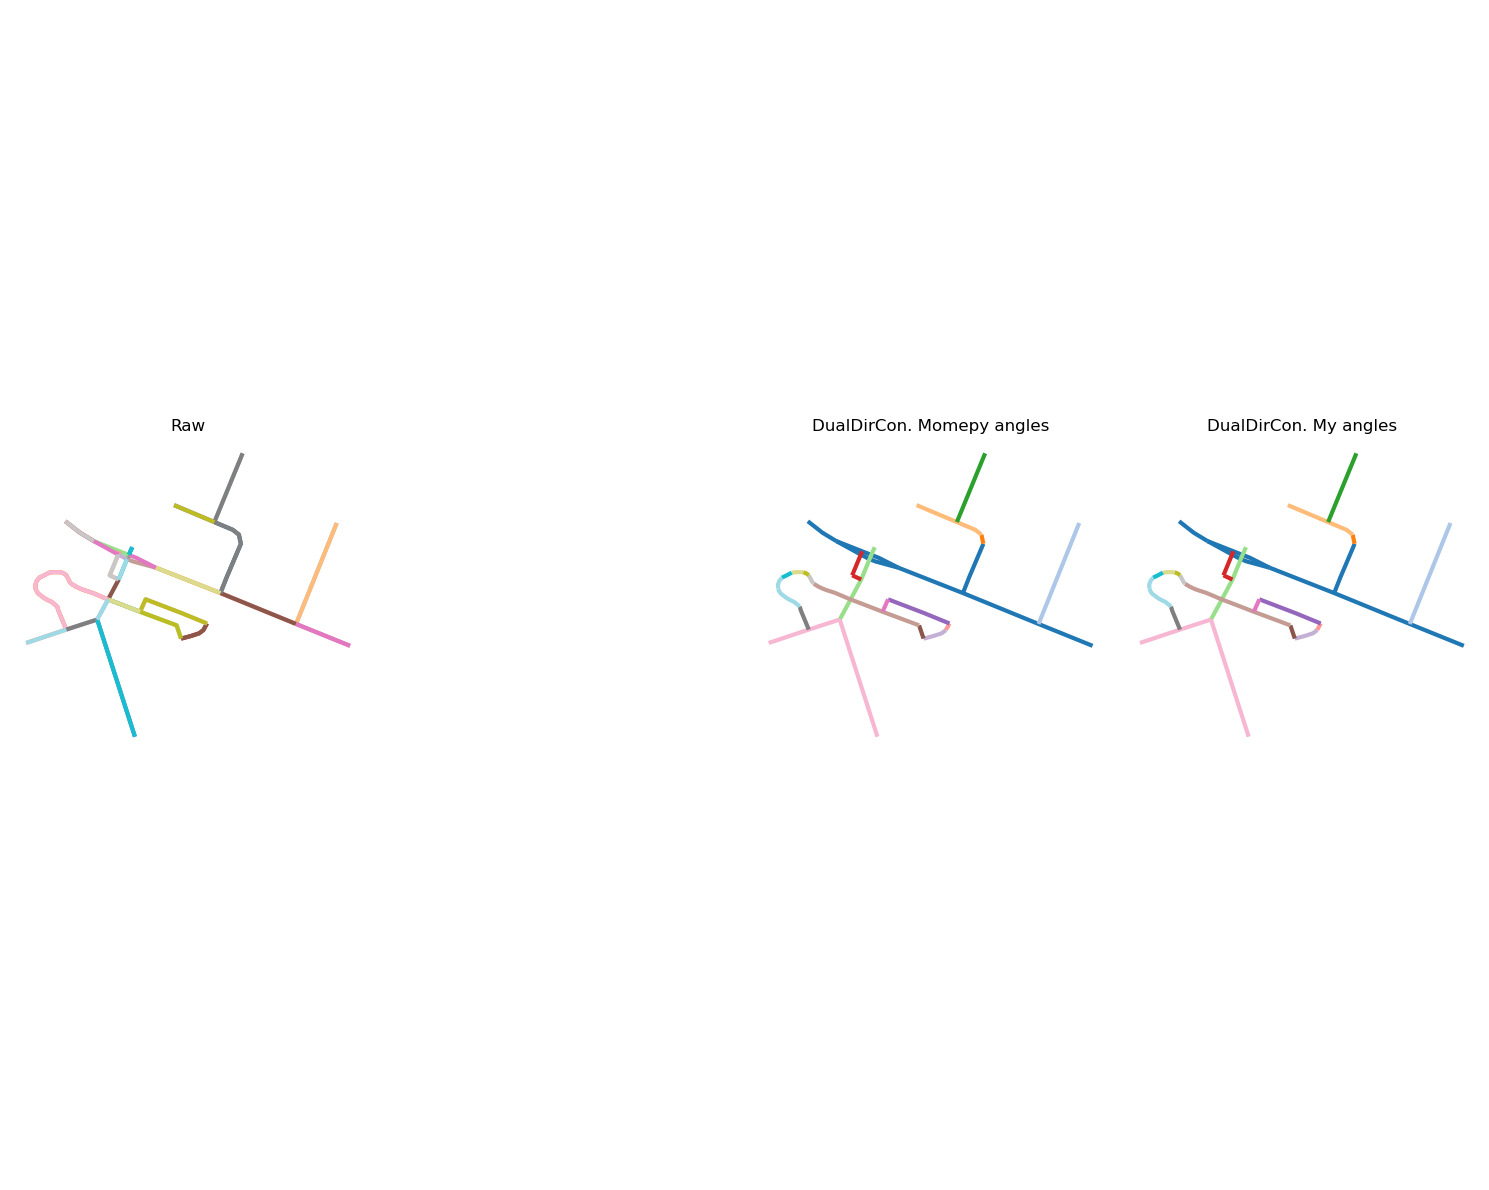

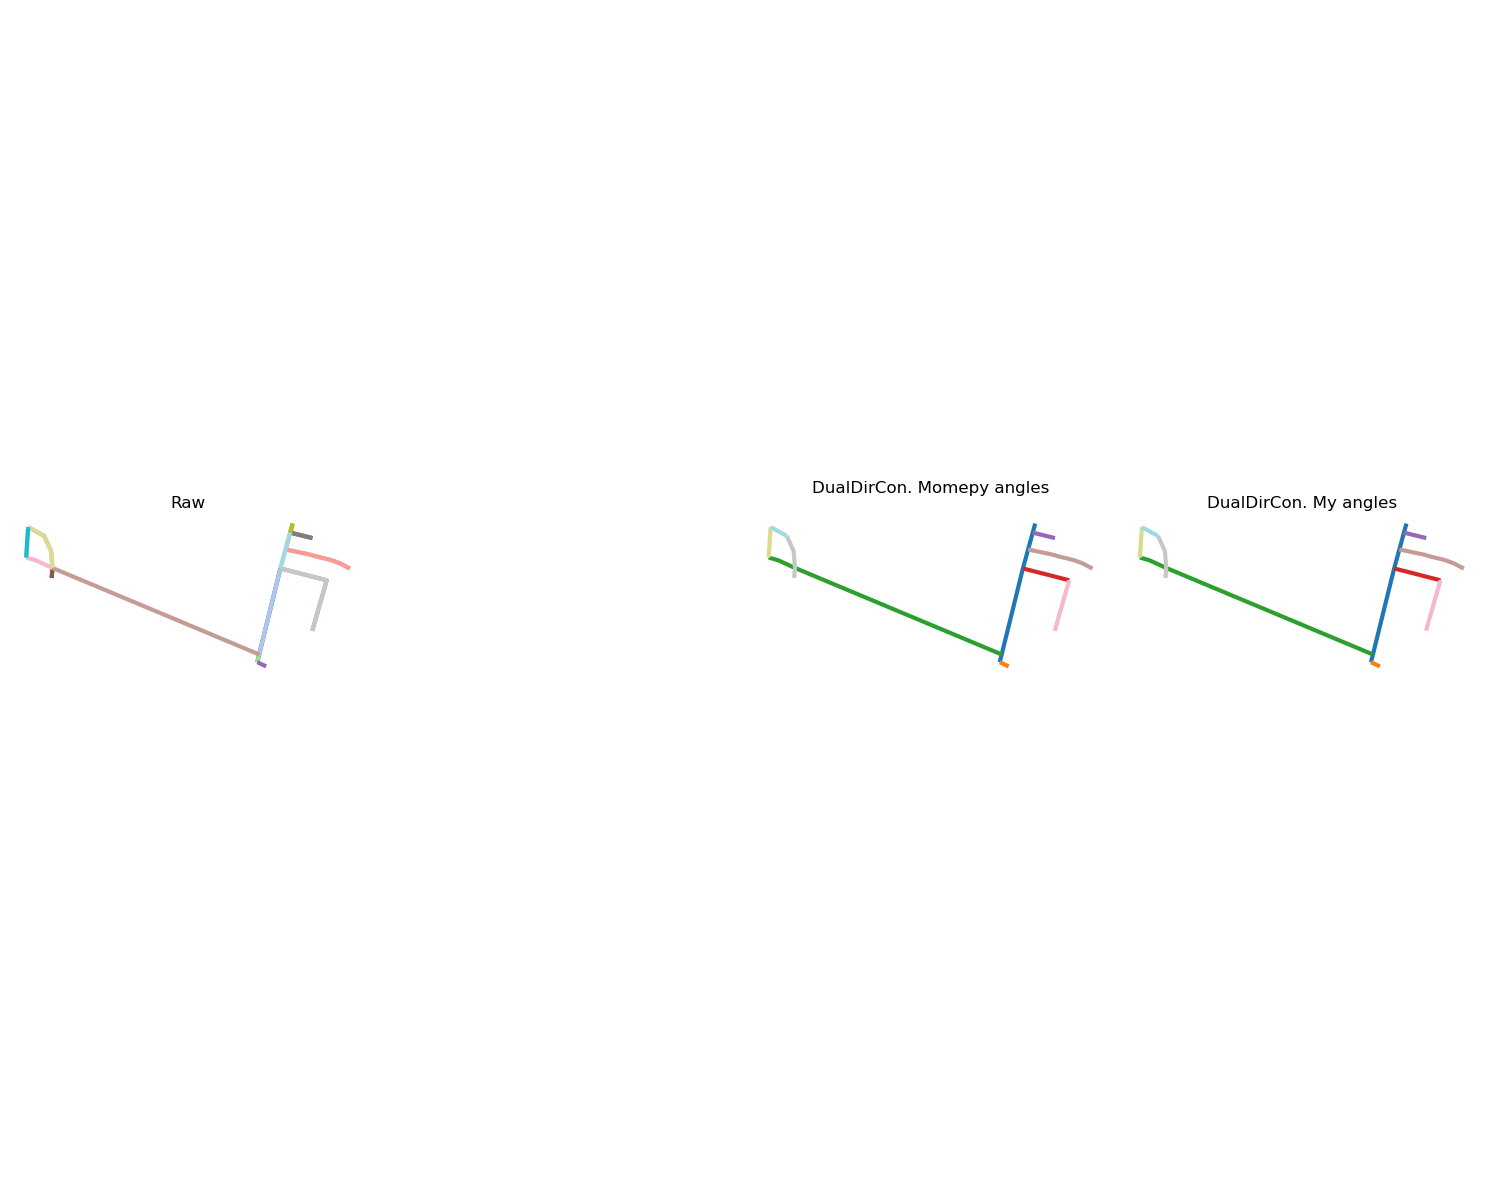

In [438]:
angle_thresholds = 20
# 52
for s in [21,101,31,53,67]:
    np.random.seed(s) 
    start = np.random.choice(list(G.nodes))
    nodes_within_4 = nx.single_source_shortest_path_length(G, start, cutoff=4)
    subG = G.subgraph(nodes_within_4.keys()).copy()

    shape_df = ox.graph_to_gdfs(subG,nodes=False)
    shape_df.crs = "epsg:4326"
    shape_df = shape_df.to_crs(3857)

    fig, axs= plt.subplots(ncols=4, nrows=1, figsize=(15,12))
    axs=axs.flatten()

    shape_df.sample(frac=1).plot(cmap='tab20',ax=axs[0],linewidth=3)
    axs[0].axis('off')
    axs[0].set_title('Raw')


    # continuity = momepy.COINS(shape_df_exploded, angle_threshold=angle_thresholds,flow_mode=True)
    # lines = continuity.stroke_gdf()
    # lines.plot(cmap='tab20',ax=axs[1],linewidth=3)
    axs[1].axis('off')
    # axs[1].set_title('momepy.COINS algorithm')

    
    # NON COINS
    shape_df = shape_df.reset_index().explode('geometry')
    shape_df = shape_df.rename(columns={'osmid': 'id'})
    u = shape_df.union_all()
    i = u.intersection(u)
    out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
    out = out.sjoin(shape_df[['id', 'geometry']], how="left", predicate="intersects")
    G_primal = momepy.gdf_to_nx(out, approach="primal")
    G_primal = clean_chains(G_primal)
    
    
    
    points, lines = momepy.nx_to_gdf(G_primal); del points
    G_dual = momepy.gdf_to_nx(lines , approach='dual', multigraph=False, angles=True)
    G_dual=new_angles(G_dual)
    
    H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=angle_thresholds,attr='angle')
    df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
    gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
    gdf_merged.plot(cmap='tab20',ax=axs[2],linewidth=3)
    axs[2].axis('off')
    axs[2].set_title('DualDirCon. Momepy angles')


    H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=angle_thresholds,attr='new_angle')
    df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
    gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
    gdf_merged.plot(cmap='tab20',linewidth=3,ax=axs[3])
    axs[3].axis('off')
    axs[3].set_title('DualDirCon. My angles')

    # shape_df_exploded.sample(frac=1).plot(cmap='tab20',ax=axs[4],linewidth=3)
    # axs[4].axis('off')
    # axs[4].set_title('exploded')


    plt.tight_layout()
    plt.show()